# CREATING IMAGES FOR README

In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import os
import re
import torch
import torchvision
from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
import dill as pickle

In [2]:
model = torch.load('./outputs/wind_turbine_detector_fold_0.model')

In [3]:
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU

In [4]:
filehandler = open('./outputs/test_data_loader.pickle', 'rb') 
test_data_loader = pickle.load(filehandler)

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
for images_batch, targets, image_ids in tqdm(test_data_loader):
    images = list(image.to(device) for image in images_batch)
    outputs = model(images)
    break

  0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
def plot_image_with_results(image, targets=None, image_id=None):
    """
    Plot an image with optional bounding box targets.

    Parameters:
    - image (torch.Tensor): The input image tensor, expected to be in the format (C, H, W).
    - targets (dict): Dictionary containing target information. Expected keys: 'boxes'.
    - image_id (str or None): Optional identifier for the image.

    Returns:
    None

    Displays the input image with bounding boxes drawn if targets are provided.
    If image_id is specified, it will be printed.

    Note:
    - The input image tensor is expected to be in PyTorch format (C, H, W).
    - The 'boxes' key in the targets dictionary should contain bounding box coordinates.
    - Bounding boxes are drawn on the image using OpenCV.

    Example:
    ```python
    plot_image_with_results(image_tensor, targets={'boxes': bounding_boxes}, image_id='123')
    ```
    """
    sample = image.permute(1,2,0).cpu().numpy()
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    if targets is not None:
        boxes = target['boxes'].cpu().numpy().astype(np.int32)
        for box in boxes:
            sample = cv2.rectangle(sample.copy(),
                                   (box[0], box[1]),
                                   (box[2], box[3]),
                                   (220, 0, 0), 5)
    if image_id is not None:
        print(image_id)
    ax.set_axis_off()
    ax.imshow(sample)
    # plt.savefig(f'image.png')

def print_layer(layers, layer):
    """
    Display and save the output of a specific layer in a neural network.

    Parameters:
    - layers (dict): Dictionary containing layer outputs. Keys are layer names, values are output tensors.
    - layer (str): Name of the layer to visualize.

    Returns:
    None

    Displays the output of the specified layer as an image and saves the figure.

    Note:
    - The layers dictionary should have layer names as keys and corresponding output tensors as values.
    - The 'layer' parameter should match the name of the layer whose output you want to visualize.
    - The output is assumed to be a 3D tensor (e.g., for a convolutional layer), and the function
      displays a 2D slice of the tensor.

    Example:
    ```python
    print_layer(model_outputs, 'conv1')
    ```

    This example assumes 'model_outputs' is a dictionary with layer names as keys and output tensors as values,
    and it displays and saves the output of the 'conv1' layer.
    """
    output_array = layers[layer][0].cpu().detach().numpy()
    print(output_array.shape)
    size = output_array.shape[2] /30
    fig, ax = plt.subplots(1, 1, figsize=(size, size))

    # Visualize the output (assuming a 3-channel image)
    ax.imshow(output_array[0, 0, :, :], cmap='viridis')
    ax.set_axis_off()
    #plt.savefig(f'saved_fig_{layer}.png')


In [8]:
outputs = {}
for idx, image in enumerate(images):
    
    outputs[idx] = {}
    outputs[idx]['image'] = image    
    target = targets[idx]
    outputs[idx]['targets'] = target
    image_id = image_ids[idx]
    outputs[idx]['image_id'] = image_id
    
    
    layers_output = {}
    # Define the hook function to get the output of layer 
    def hook_fn(module, input, output, layer=1):
        if layer in layers_output:
            layers_output[layer].append(output)
        else:
            layers_output[layer] = [output]
    # Register the hook to the desired layer
    hook1 = model.backbone.body.layer1.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, layer=1))
    hook2 = model.backbone.body.layer2.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, layer=2))
    hook3 = model.backbone.body.layer3.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, layer=3))
    hook4 = model.backbone.body.layer4.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, layer=4))
    # Inner blocks these are the 1x1 convolutions applied to the feature maps at different stages of the backbone.
    hook_p2 = model.backbone.fpn.inner_blocks[0].register_forward_hook(lambda module, input, output: hook_fn(module, input, output, layer='P2'))
    hook_p3 = model.backbone.fpn.inner_blocks[1].register_forward_hook(lambda module, input, output: hook_fn(module, input, output, layer='P3'))
    hook_p4 = model.backbone.fpn.inner_blocks[2].register_forward_hook(lambda module, input, output: hook_fn(module, input, output, layer='P4'))
    hook_p4 = model.backbone.fpn.inner_blocks[3].register_forward_hook(lambda module, input, output: hook_fn(module, input, output, layer='P5'))
    # These are the 3x3 convolutions applied to merge feature maps from the bottom-up pathway and the top-down pathway.
    hook_M5 = model.backbone.fpn.layer_blocks[0].register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'M5'))
    hook_M4 = model.backbone.fpn.layer_blocks[1].register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'M4'))
    hook_M3 = model.backbone.fpn.layer_blocks[2].register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'M3'))
    hook_M2 = model.backbone.fpn.layer_blocks[3].register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'M2'))
    hook_RPN_cls_logits = model.rpn.head.cls_logits.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'RPN_cls_logits'))
    hook_RPN_bbox_pred = model.rpn.head.bbox_pred.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'RPN_bbox_pred'))
    hook_RPN_conv = model.rpn.head.conv.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'RPN_conv'))
    hook_RPN_conv_input = model.rpn.head.conv.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'RPN_conv_input'))

    hook_RPN_anchor = model.rpn.anchor_generator.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'RPN_anchor'))
    # Forward pass through the model
    output_list = model(image.unsqueeze(0))
    # Remove the hook to avoid interference with future forward passes
    hook1.remove()
    hook2.remove()
    hook3.remove()
    hook4.remove()
    hook_p2.remove()
    hook_p3.remove()
    hook_p4.remove()
    hook_M5.remove()
    hook_M4.remove()
    hook_M3.remove()
    hook_M2.remove()
    hook_RPN_cls_logits.remove()
    hook_RPN_bbox_pred.remove()
    hook_RPN_conv.remove()
    hook_RPN_conv_input.remove()
    hook_RPN_anchor.remove()
    
    outputs[idx]['layers'] = layers_output
    outputs[idx]['model_output'] = output_list[0]

## INPUT IMAGE

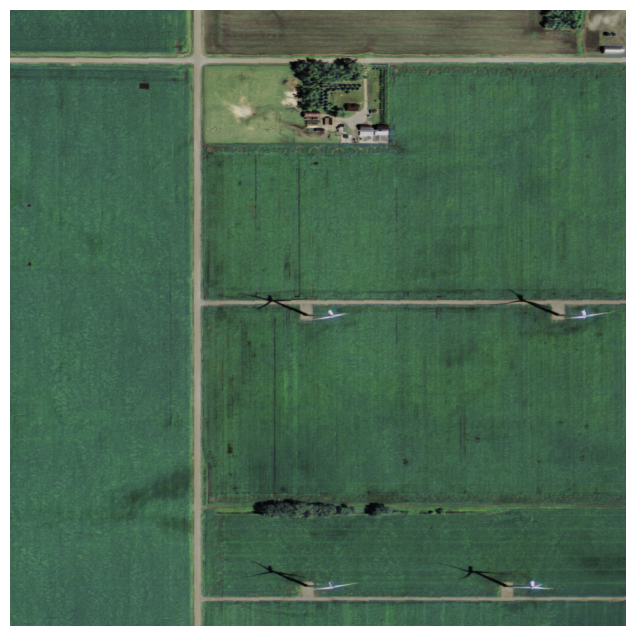

In [9]:
plot_image_with_results(outputs[6]['image'])

## FEATURE PYRAMIDS NETWORK LAYERS

(1, 256, 200, 200)


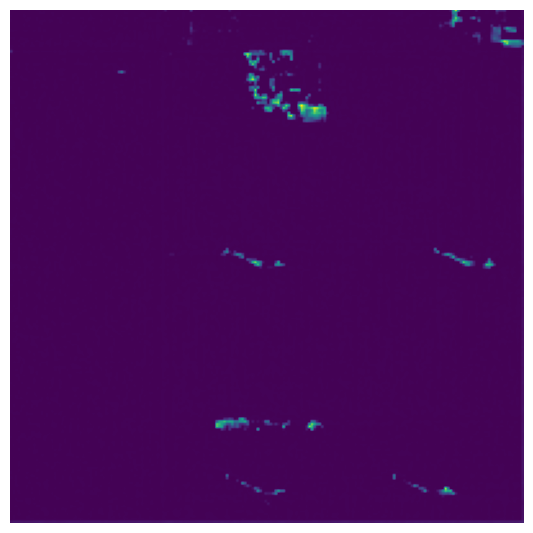

In [10]:
 print_layer(outputs[6]['layers'] , 1)

(1, 512, 100, 100)


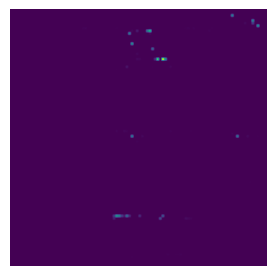

In [11]:
 print_layer(outputs[6]['layers'] ,2)

(1, 1024, 50, 50)


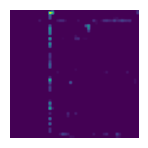

In [12]:
 print_layer(outputs[6]['layers'] , 3)

(1, 2048, 25, 25)


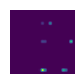

In [13]:
 print_layer(outputs[6]['layers'] , 4)

(1, 256, 200, 200)


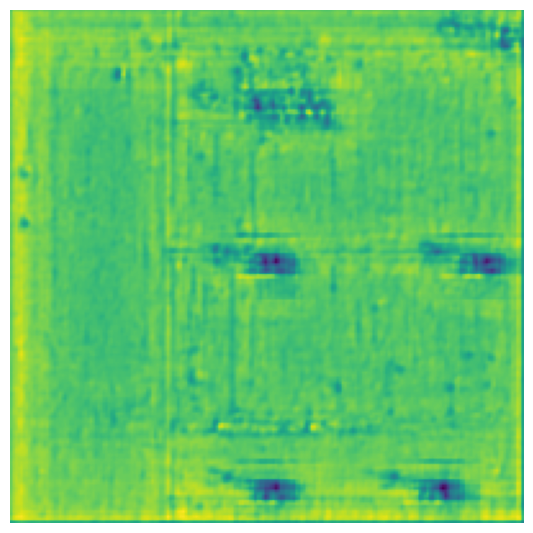

In [14]:
 print_layer(outputs[6]['layers'] , 'M5')

(1, 256, 100, 100)


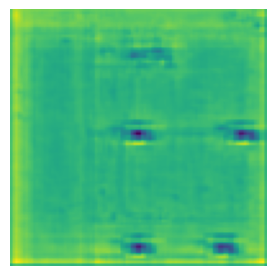

In [15]:
 print_layer(outputs[6]['layers'] , 'M4')

(1, 256, 50, 50)


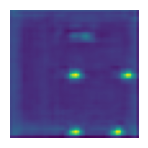

In [16]:
 print_layer(outputs[6]['layers'] , 'M3')

(1, 256, 25, 25)


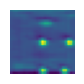

In [17]:
 print_layer(outputs[6]['layers'] , 'M2')

(1, 256, 200, 200)


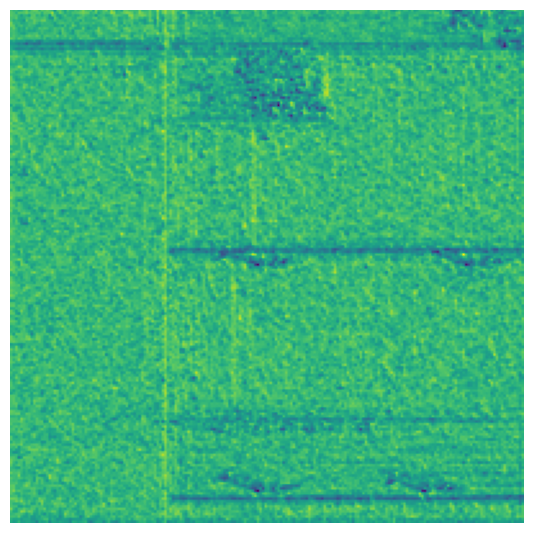

In [18]:
 print_layer(outputs[6]['layers'] , 'P2')

(1, 256, 100, 100)


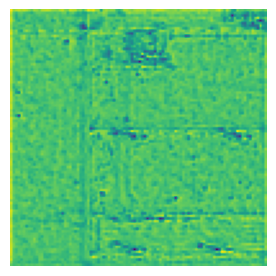

In [19]:
 print_layer(outputs[6]['layers'] , 'P3')

(1, 256, 50, 50)


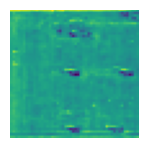

In [20]:
 print_layer(outputs[6]['layers'] , 'P4')

(1, 256, 25, 25)


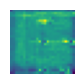

In [21]:
 print_layer(outputs[6]['layers'] , 'P5')

# RPN Objectness

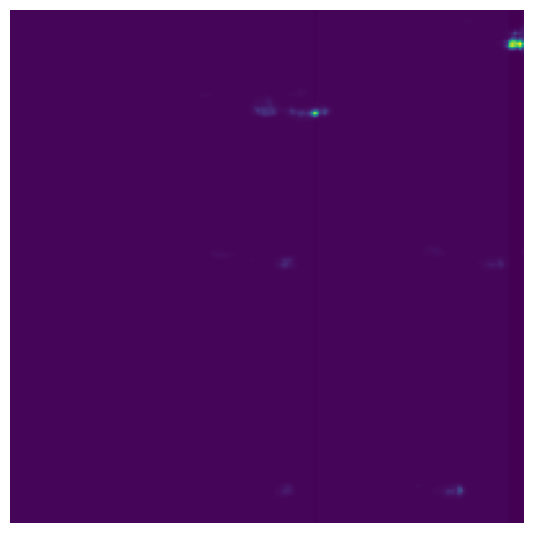

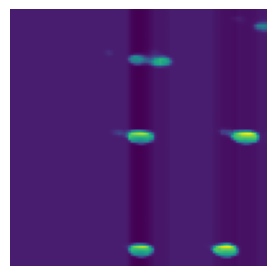

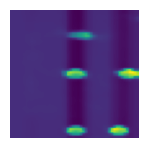

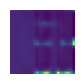

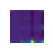

In [22]:
for idx in range(0,len(outputs[6]['layers']['RPN_cls_logits'])):
    cls_logits = outputs[6]['layers']['RPN_cls_logits'][idx][0,0].cpu().detach().numpy()
    bbox_pred = outputs[6]['layers']['RPN_bbox_pred'][idx][0, 1].cpu().detach().numpy()

    # Apply softmax-like operation to classification scores
    cls_probs = 1 / (1 + torch.exp(-torch.Tensor(cls_logits))).cpu().detach().numpy()


    # Combine cls_probs and bbox_pred to create an informed objectness map
    objectness_map = cls_probs * (1 + bbox_pred)

    def softmax(x):
        e_x = np.exp(x - np.max(x))  # Subtracting np.max(x) for numerical stability
        return e_x / e_x.sum(axis=0)

    # Assuming 'objectness_map' is your combined score
    combined_scores = objectness_map

    # Applying softmax
    objectness_probs = softmax(combined_scores)

    size = objectness_probs.shape[0] /30
    fig, ax = plt.subplots(1, 1, figsize=(size, size))
    
    # Plot the objectness map
    ax.imshow(objectness_probs, cmap='viridis')
    ax.set_axis_off()
    #plt.colorbar()
    #plt.title('Objectness Map (Approximation)')
    plt.savefig(f'saved_fig_{str(idx)+"-objmap"}.png')